<a href="https://colab.research.google.com/github/brendonborck/Teste/blob/master/EXAME_CMC12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 18.0 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=cff69e3ade1bef984bf2d6732f40c289bb4fa4b72dce1d86241c059da189e266
  Stored in directory: /root/.cache/pip/wheels/48/ef/c2/929bb5c59a1328df00a0561d0e68cd7c8537f33f5ce0ce741b
Successfully built control


### **Design**

Package initialization

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi
import control as ct

Vehicle model

In [ ]:
def vehicle_update(t, x, u, params={}):
    """Vehicle dynamics for cruise control system.

    Parameters
    ----------
    x : array
         System state: car velocity in m/s
    u : array
         System input: [throttle, gear, road_slope], where throttle is
         a float between 0 and 1, gear is an integer between 1 and 5,
         and road_slope is in rad.

    Returns
    -------
    float
        Vehicle acceleration
    """

    from math import copysign, sin
    sign = lambda x: copysign(1, x)         # define the sign() function
    
    # Set up the system parameters
    m = params.get('m', 1600.)              # vehicle mass, kg
    g = params.get('g', 9.8)                # gravitational constant, m/s^2
    Cr = params.get('Cr', 0.01)             # coefficient of rolling friction
    Cd = params.get('Cd', 0.32)             # drag coefficient
    rho = params.get('rho', 1.3)            # density of air, kg/m^3
    A = params.get('A', 2.4)                # car area, m^2
    alpha = params.get(
        'alpha', [40, 25, 16, 12, 10])      # gear ratio / wheel radius

    # Define variables for vehicle state and inputs
    v = x[0]                           # vehicle velocity
    throttle = np.clip(u[0], 0, 1)     # vehicle throttle
    gear = u[1]                        # vehicle gear
    theta = u[2]                       # road slope

    # Force generated by the engine
    omega = alpha[int(gear)-1] * v      # engine angular speed
    F = alpha[int(gear)-1] * motor_torque(omega, params) * throttle

    # Disturbance forces
    #
    # The disturbance force Fd has three major components: Fg, the forces due
    # to gravity; Fr, the forces due to rolling friction; and Fa, the
    # aerodynamic drag.

    # Letting the slope of the road be \theta (theta), gravity gives the
    # force Fg = m g sin \theta.
    Fg = m * g * sin(theta)

    # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
    # the coefficient of rolling friction and sgn(v) is the sign of v (±1) or
    # zero if v = 0.
    Fr  = m * g * Cr * sign(v)

    # The aerodynamic drag is proportional to the square of the speed: Fa =
    # 1/2 \rho Cd A |v| v, where \rho is the density of air, Cd is the
    # shape-dependent aerodynamic drag coefficient, and A is the frontal area
    # of the car.
    Fa = 1/2 * rho * Cd * A * abs(v) * v
    
    # Final acceleration on the car
    Fd = Fg + Fr + Fa
    dv = (F - Fd) / m
    
    return dv


Engine model

In [ ]:
def motor_torque(omega, params={}):
    # Set up the system parameters
    Tm = params.get('Tm', 190.)             # engine torque constant
    omega_m = params.get('omega_m', 420.)   # peak engine angular speed
    beta = params.get('beta', 0.4)          # peak engine rolloff

    return np.clip(Tm * (1 - beta * (omega/omega_m - 1)**2), 0, None)

Input/output model for the vehicle system

In [ ]:
vehicle = ct.NonlinearIOSystem(
    vehicle_update, None, name='vehicle',
    inputs = ('u', 'gear', 'theta'), outputs = ('v'), states=('v'))

Input/output torque curves (plot)

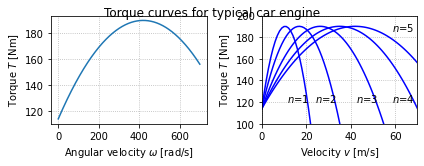

In [ ]:
# Figure 4.2a - single torque curve as function of omega
omega_range = np.linspace(0, 700, 701)
plt.subplot(2, 2, 1)
plt.plot(omega_range, [motor_torque(w) for w in omega_range])
plt.xlabel('Angular velocity $\omega$ [rad/s]')
plt.ylabel('Torque $T$ [Nm]')
plt.grid(True, linestyle='dotted')

# Figure 4.2b - torque curves in different gears, as function of velocity
plt.subplot(2, 2, 2)
v_range = np.linspace(0, 70, 71)
alpha = [40, 25, 16, 12, 10]
for gear in range(5):
    omega_range = alpha[gear] * v_range
    plt.plot(v_range, [motor_torque(w) for w in omega_range],
             color='blue', linestyle='solid')

# Set up the axes and style
plt.axis([0, 70, 100, 200])
plt.grid(True, linestyle='dotted')

# Add labels
plt.text(11.5, 120, '$n$=1')
plt.text(24, 120, '$n$=2')
plt.text(42.5, 120, '$n$=3')
plt.text(58.5, 120, '$n$=4')
plt.text(58.5, 185, '$n$=5')
plt.xlabel('Velocity $v$ [m/s]')
plt.ylabel('Torque $T$ [Nm]')

plt.suptitle('Torque curves for typical car engine');
plt.tight_layout()
plt.savefig("cruise-gearcurves.png", bbox_inches='tight')

PI controller

In [ ]:
# Construct a PI controller with rolloff, as a transfer function
Kp = 0.5                        # proportional gain
Ki = 0.1                        # integral gain
control_pi = ct.tf2io(
    ct.TransferFunction([Kp, Ki], [1, 0.01*Ki/Kp]),
    name='control', inputs='u', outputs='y')

cruise_pi = ct.InterconnectedSystem(
    (vehicle, control_pi), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

Plotting function

In [ ]:
# Define a generator for creating a "standard" cruise control plot
def cruise_plot(sys, t, y, t_hill=5, vref=20, antiwindup=False, linetype='b-',
               subplots=[None, None]):
    # Figure out the plot bounds and indices
    v_min = vref-1.2; v_max = vref+0.5; v_ind = sys.find_output('v')
    u_min = 0; u_max = 2 if antiwindup else 1; u_ind = sys.find_output('u')

    # Make sure the upper and lower bounds on v are OK
    while max(y[v_ind]) > v_max: v_max += 1
    while min(y[v_ind]) < v_min: v_min -= 1
        
    # Create arrays for return values
    subplot_axes = subplots.copy()

    # Velocity profile
    if subplot_axes[0] is None:
        subplot_axes[0] = plt.subplot(2, 1, 1)
    else:
        plt.sca(subplots[0])
    plt.plot(t, y[v_ind], linetype)
    plt.plot(t, vref*np.ones(t.shape), 'k-')
    plt.plot([t_hill, t_hill], [v_min, v_max], 'k--')
    plt.axis([0, t[-1], v_min, v_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Velocity $v$ [m/s]')

    # Commanded input profile
    if subplot_axes[1] is None:
        subplot_axes[1] = plt.subplot(2, 1, 2)
    else:
        plt.sca(subplots[1])
    plt.plot(t, y[u_ind], 'r--' if antiwindup else linetype)
    plt.plot([t_hill, t_hill], [u_min, u_max], 'k--')
    plt.axis([0, t[-1], u_min, u_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Throttle $u$')

    # Applied input profile
    if antiwindup:
        plt.plot(t, np.clip(y[u_ind], 0, 1), linetype)
        plt.legend(['Commanded', 'Applied'], frameon=False)
        
    return subplot_axes

Trajectory description

In [ ]:
# Define the time and input vectors
T = np.linspace(0, 25, 101)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Effect of a hill at t = 5 seconds
theta_hill = np.array([
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T])

Simulated responses (plot)

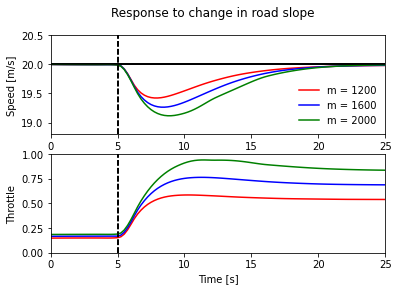

In [ ]:
# Simulate and plot
plt.figure()
plt.suptitle('Response to change in road slope')

subplots = [None, None]
linecolor = ['red', 'blue', 'green']
handles = []
for i, m in enumerate([1200, 1600, 2000]):
    # Compute the equilibrium state for the system
    X0, U0 = ct.find_eqpt(
        cruise_pi, [vref[0], 0], [vref[0], gear[0], theta0[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0], params={'m':m})

    t, y = ct.input_output_response(
        cruise_pi, T, [vref, gear, theta_hill], X0, params={'m':m})

    subplots = cruise_plot(cruise_pi, t, y, t_hill=5, subplots=subplots,
                           linetype=linecolor[i][0] + '-')
    handles.append(mpl.lines.Line2D([], [], color=linecolor[i], 
                   linestyle='-', label="m = %d" % m))

# Add labels to the plots
plt.sca(subplots[0])
plt.ylabel('Speed [m/s]')
plt.legend(handles=handles, frameon=False, loc='lower right');

plt.sca(subplots[1])
plt.ylabel('Throttle')
plt.xlabel('Time [s]');
plt.savefig("cruise-speedresp.png", bbox_inches='tight')

### **Linearized Dynamics**

Linearized dynamics

In [ ]:
# Find the equilibrium point for the system
Xeq, Ueq = ct.find_eqpt(
    vehicle, [vref[0]], [0, gear[0], theta0[0]], y0=[vref[0]], iu=[1, 2])
print("Xeq = ", Xeq, "\nUeq = ", Ueq)

# Compute the linearized system at the eq pt
vehlin = ct.linearize(vehicle, Xeq, [Ueq[0], gear[0], 0], name='vehlin', copy=True)

Xeq =  [20.] 
Ueq =  [0.16874874 4.         0.        ]


PI controller with anti-windup compensation

In [ ]:
def pi_update(t, x, u, params={}):
    # Get the controller parameters that we need
    ki = params.get('ki', 0.1)
    kaw = params.get('kaw', 2)  # anti-windup gain

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # Compute the nominal controller output (needed for anti-windup)
    u_a = pi_output(t, x, u, params)

    # Compute anti-windup compensation (scale by ki to account for structure)
    u_aw = kaw/ki * (np.clip(u_a, 0, 1) - u_a) if ki != 0 else 0

    # State is the integrated error, minus anti-windup compensation
    return (vref - v) + u_aw

def pi_output(t, x, u, params={}):
    # Get the controller parameters that we need
    kp = params.get('kp', 0.5)
    ki = params.get('ki', 0.1)

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # PI controller
    return kp * (vref - v) + ki * z

control_pi_aw = ct.NonlinearIOSystem(
    pi_update, pi_output, name='control',
    inputs = ['v', 'vref'], outputs = ['u'], states = ['z'],
    params = {'kp':0.5, 'ki':0.1})

# Create a closed loop controller for the linear system
cruise_lin = ct.InterconnectedSystem(
    (vehlin, control_pi_aw), name='cruise_lin',
    connections=(
        ('vehlin.u', 'control.u'),
        ('control.v', 'vehlin.v')),
    inplist=('control.vref', 'vehlin.gear', 'vehlin.theta'),
    outlist=('control.u', 'vehlin.v'), outputs=['u', 'v'])

# Create a closed loop controller for the nonlinear system
cruise_nonlin = ct.InterconnectedSystem(
    (vehicle, control_pi_aw), name='cruise_nonlin',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.v', 'vehicle.v')),
    inplist=('control.vref', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

Simulations

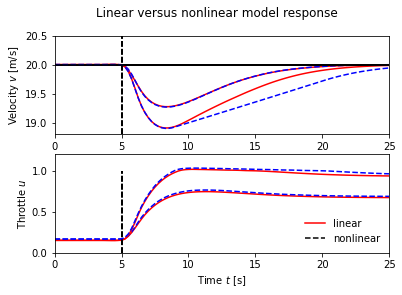

In [ ]:
# Linear response
X0_lin, U0 = ct.find_eqpt(
    cruise_lin, [vref[0], 0], [vref[0], gear[0], theta0[0]],
    y0=[0, vref[0]], iu=[1, 2], iy=[1])

t, y = ct.input_output_response(cruise_lin, T, [vref, gear, theta_hill], X0_lin)
subplots = cruise_plot(cruise_lin, t, y, t_hill=5, linetype='r-')

# Nonlinear response
X0_nonlin, U0 = ct.find_eqpt(
    cruise_nonlin, [vref[0], 0], [vref[0], gear[0], theta0[0]],
    y0=[0, vref[0]], iu=[1, 2], iy=[1])

t, y = ct.input_output_response(cruise_nonlin, T, [vref, gear, theta_hill], X0_nonlin)
subplots = cruise_plot(cruise_nonlin, t, y, t_hill=5, subplots=subplots, linetype='b--') 

# Add a legend to identify linear vs nonlinear
plt.legend(['linear', 'nonlinear'], frameon=False, loc='lower right')

# Add two more simulations for 6 degree hill instead of 4 degree
t, y = ct.input_output_response(cruise_lin, T, [vref, gear, theta_hill*1.5], X0_lin)
subplots = cruise_plot(cruise_lin, t, y, t_hill=5, subplots=subplots, linetype='r-') 

t, y = ct.input_output_response(cruise_nonlin, T, [vref, gear, theta_hill*1.5], X0_nonlin)
subplots = cruise_plot(cruise_nonlin, t, y, t_hill=5, subplots=subplots, linetype='b--') 

# Add titles and legends and save the figure
plt.suptitle('Linear versus nonlinear model response')
plt.sca(subplots[1]); plt.axis([0, 25, 0, 1.2])

plt.savefig("cruise-linear_vs_nonlinear.png", bbox_inches='tight')

### **State Space Control**

State feedback controller

In [ ]:
def sf_update(t, z, u, params={}):
    y, r = u[1], u[2]
    return y - r

def sf_output(t, z, u, params={}):
    # Get the controller parameters that we need
    K = params.get('K', 0)
    ki = params.get('ki', 0)
    kf = params.get('kf', 0)
    xd = params.get('xd', 0)
    yd = params.get('yd', 0)
    ud = params.get('ud', 0)

    # Get the system state and reference input
    x, y, r = u[0], u[1], u[2]

    return ud - K * (x - xd) - ki * z + kf * (r - yd)

# Create the input/output system for the controller
control_sf = ct.NonlinearIOSystem(
    sf_update, sf_output, name='control',
    inputs=('x', 'y', 'r'),
    outputs=('u'),
    states=('z'))

# Create the closed loop system for the state space controller
cruise_sf = ct.InterconnectedSystem(
    (vehicle, control_sf), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.x', 'vehicle.v'),
        ('control.y', 'vehicle.v')),
    inplist=('control.r', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

# Construct the gain matrices for the system
A, B, C = vehlin.A, vehlin.B[0, 0], vehlin.C
K = 0.5
kf = -1 / (C * np.linalg.inv(A - B * K) * B)

# Compute the steady state velocity and throttle setting
xd = Xeq[0]
ud = Ueq[0]
yd = vref[-1]

Simulation (plot)

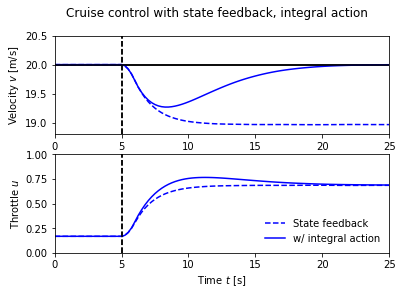

In [ ]:
# Response of the system with no integral feedback term
t, y_sfb = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [Xeq[0], 0],
    params={'K':K, 'ki':0.0, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
subplots = cruise_plot(cruise_sf, t, y_sfb, t_hill=5, linetype='b--')

# Response of the system with state feedback + integral action
t, y_sfb_int = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [Xeq[0], 0],
    params={'K':K, 'ki':0.1, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
cruise_plot(cruise_sf, t, y_sfb_int, t_hill=5, linetype='b-', subplots=subplots)

# Add title and legend
plt.suptitle('Cruise control with state feedback, integral action')
p_line = mpl.lines.Line2D([], [], color='blue', linestyle='--', label='State feedback')
pi_line = mpl.lines.Line2D([], [], color='blue', linestyle='-', label='w/ integral action')
plt.legend(handles=[p_line, pi_line], frameon=False, loc='lower right')
plt.savefig("cruise-statefbk.png", bbox_inches='tight')

### **PID Control**

Get transfer function parameters

In [ ]:
# Get the transfer function from throttle input + hill to vehicle speed
P = ct.ss2tf(vehlin[0, 0])

# Construction a controller that cancels the pole
a = -P.pole()[0]
b = np.real(P(0)) * a

Fix w_c and vary zeta_c(plot)

/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


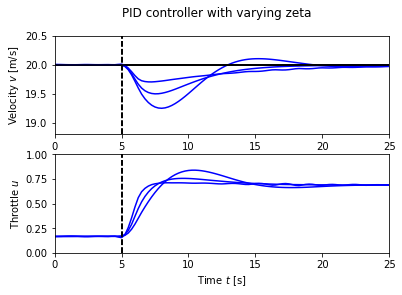

In [ ]:
# Fix \omega_0 and vary \zeta
w0 = 0.5
subplots = [None, None]
for zeta in [0.5, 1, 2]:
    # Create the controller transfer function (as an I/O system)
    kp = (2*zeta*w0 - a)/b
    ki = w0**2 / b
    control_tf = ct.tf2io(
        ct.TransferFunction([kp, ki], [1, 0.01*ki/kp]),
        name='control', inputs='u', outputs='y')
    
    # Construct the closed loop system by interconnecting process and controller
    cruise_tf = ct.InterconnectedSystem(
    (vehicle, control_tf), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), 
        inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta_hill[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(cruise_tf, T, [vref, gear, theta_hill], X0)
    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)

plt.suptitle('PID controller with varying zeta')
plt.savefig("cruise-pid-sweep-zeta.png", bbox_inches='tight')

Fix vary zeta_c and w_c (plot)

/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


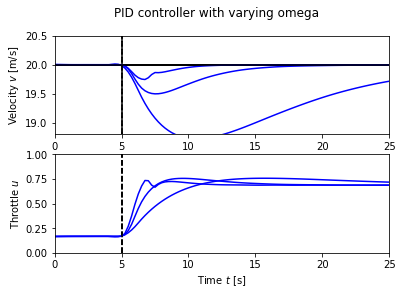

In [ ]:
zeta = 1
subplots = [None, None]
for w0 in [0.2, 0.5, 1]:
    # Create the controller transfer function (as an I/O system)
    kp = (2*zeta*w0 - a)/b
    ki = w0**2 / b
    control_tf = ct.tf2io(
        ct.TransferFunction([kp, ki], [1, 0.01*ki/kp]),
        name='control', inputs='u', outputs='y')
    
    # Construct the closed loop system by interconnecting process and controller
    cruise_tf = ct.InterconnectedSystem(
        (vehicle, control_tf), name='cruise',
        connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
        inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), 
        inputs = ('vref', 'gear', 'theta'),
        outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta_hill[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(cruise_tf, T, [vref, gear, theta_hill], X0)
    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)

plt.suptitle('PID controller with varying omega')
plt.savefig("cruise-pid-sweep-omega.png", bbox_inches='tight')

Fix w_c and vary zeta_c (plot)

/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


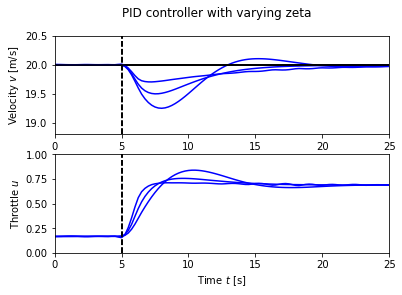

In [ ]:
# Fix \omega_0 and vary \zeta
w0 = 0.5
subplots = [None, None]
for zeta in [0.5, 1, 2]:
    # Create the controller transfer function (as an I/O system)
    kp = (2*zeta*w0 - a)/b
    ki = w0**2 / b
    control_tf = ct.tf2io(
        ct.TransferFunction([kp, ki], [1, 0.01*ki/kp]),
        name='control', inputs='u', outputs='y')
    
    # Construct the closed loop system by interconnecting process and controller
    cruise_tf = ct.InterconnectedSystem(
    (vehicle, control_tf), name='cruise',
    connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), 
        inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta_hill[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(cruise_tf, T, [vref, gear, theta_hill], X0)
    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)

plt.suptitle('PID controller with varying zeta')
plt.savefig("cruise-pid-sweep-zeta.png", bbox_inches='tight')

Fix vary w_c and zeta_c (plot)

/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
/usr/local/lib/python3.7/dist-packages/control/statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


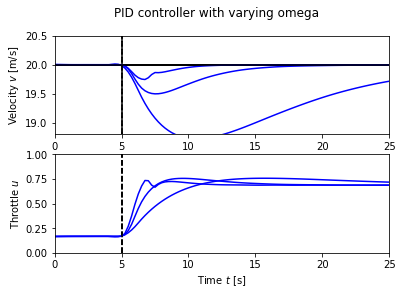

In [ ]:
zeta = 1
subplots = [None, None]
for w0 in [0.2, 0.5, 1]:
    # Create the controller transfer function (as an I/O system)
    kp = (2*zeta*w0 - a)/b
    ki = w0**2 / b
    control_tf = ct.tf2io(
        ct.TransferFunction([kp, ki], [1, 0.01*ki/kp]),
        name='control', inputs='u', outputs='y')
    
    # Construct the closed loop system by interconnecting process and controller
    cruise_tf = ct.InterconnectedSystem(
        (vehicle, control_tf), name='cruise',
        connections = [('control.u', '-vehicle.v'), ('vehicle.u', 'control.y')],
        inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'), 
        inputs = ('vref', 'gear', 'theta'),
        outlist = ('vehicle.v', 'vehicle.u'), outputs = ('v', 'u'))

    # Plot the velocity response
    X0, U0 = ct.find_eqpt(
        cruise_tf, [vref[0], 0], [vref[0], gear[0], theta_hill[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0])

    t, y = ct.input_output_response(cruise_tf, T, [vref, gear, theta_hill], X0)
    subplots = cruise_plot(cruise_tf, t, y, t_hill=5, subplots=subplots)

plt.suptitle('PID controller with varying omega')
plt.savefig("cruise-pid-sweep-omega.png", bbox_inches='tight')

### **Anti-windup compensation**

Redefine input with longer duration

In [ ]:
T = np.linspace(0, 50, 101)
vref = 20 * np.ones(T.shape)
theta_hill = [
    0 if t <= 5 else
    6./180. * pi * (t-5) if t <= 6 else
    6./180. * pi for t in T]

# Compute the equilibrium throttle setting for the desired speed
X0, U0 = ct.find_eqpt(
    cruise_nonlin, [vref[0], 0], [vref[0], gear[0], theta0[0]],
    y0=[0, vref[0]], iu=[1, 2], iy=[1])

Effects of windup (plot)

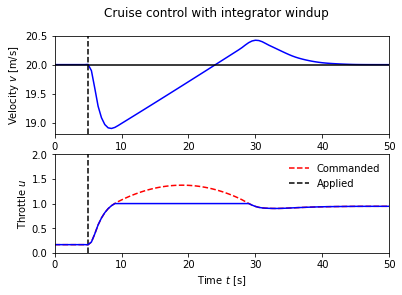

In [ ]:
t, y = ct.input_output_response(
    cruise_nonlin, T, [vref, gear, theta_hill], X0,
    params={'kaw':0})
cruise_plot(cruise_nonlin, t, y, antiwindup=True);

plt.suptitle('Cruise control with integrator windup')
plt.savefig("cruise-windup.png", bbox_inches='tight')

Anti-windup compensation (plot)

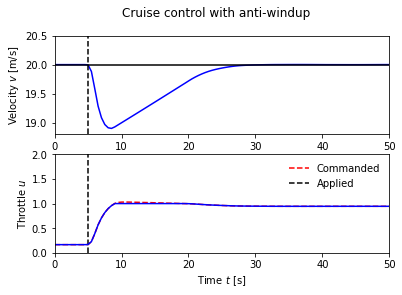

In [ ]:
t, y = ct.input_output_response(
    cruise_nonlin, T, [vref, gear, theta_hill], X0,
    params={'kaw':2})
cruise_plot(cruise_nonlin, t, y, antiwindup=True);

plt.suptitle('Cruise control with anti-windup')
plt.savefig("cruise-antiwindup.png", bbox_inches='tight')